<a href="https://colab.research.google.com/github/andradhf/water-level-anomaly-detection/blob/main/OCSVM_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

#Algorithm
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

##Import Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Water_level_dataset/water_level_dataset.csv', index_col=0)
df_test = pd.read_csv('/content/drive/MyDrive/Water_level_dataset/water_level_label.csv', index_col=0)

In [4]:
df.head()

,water_level
timestamp,
2023-01-01 00:40:00,0.495016
2023-01-01 01:25:00,0.547955
2023-01-01 02:10:00,0.652855
2023-01-01 02:55:01,0.728848
2023-01-01 03:40:00,0.802187


In [5]:
df_test.head()

,water_level,label
timestamp,,
2024-12-01 02:55:00,0.609146,0
2024-12-01 03:30:00,0.716856,0
2024-12-01 04:05:00,0.793186,0
2024-12-01 04:40:00,0.887867,0
2024-12-01 05:15:00,1.011236,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11677 entries, 2023-01-01 00:40:00 to 2023-12-31 23:55:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   water_level  11677 non-null  float64
dtypes: float64(1)
memory usage: 182.5+ KB


In [7]:
df.describe()

,water_level
count,11677.000000
mean,0.686107
std,0.265425
min,0.013859
25%,0.490089
50%,0.688873
75%,0.886564
max,1.448410


In [8]:
df.shape

(11677, 1)

##Cleaning Data

In [9]:
print('Duplicated: ', df.duplicated().sum())

Duplicated:  318


In [10]:
df.shape

(11677, 1)

In [11]:
df = df.drop_duplicates()
print('Duplicated: ', df.duplicated().sum())
df.shape

Duplicated:  0


(11359, 1)

In [12]:
df.isnull().sum()

,0
water_level,0


##Exploratory Data Analysis(EDA)

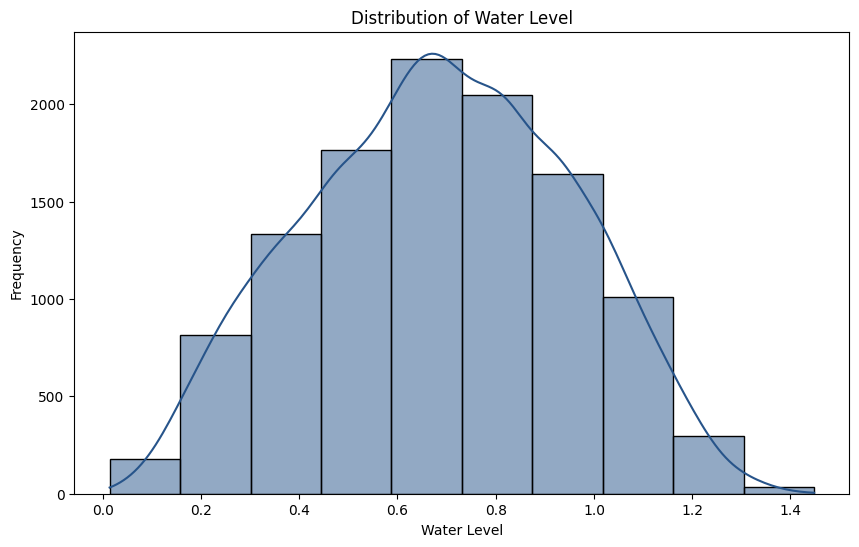

In [13]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='water_level', bins=10, kde=True, color='#27548A')

plt.title('Distribution of Water Level')
plt.xlabel('Water Level')
plt.ylabel('Frequency')
plt.show()

In [14]:
df.skew()

,0
water_level,-0.042733


##Data Preparation

In [15]:
df_test.head()

,water_level,label
timestamp,,
2024-12-01 02:55:00,0.609146,0
2024-12-01 03:30:00,0.716856,0
2024-12-01 04:05:00,0.793186,0
2024-12-01 04:40:00,0.887867,0
2024-12-01 05:15:00,1.011236,0


In [16]:
df_test = df_test.drop(columns=['label'])
df_test

,water_level
timestamp,
2024-12-01 02:55:00,0.609146
2024-12-01 03:30:00,0.716856
2024-12-01 04:05:00,0.793186
2024-12-01 04:40:00,0.887867
2024-12-01 05:15:00,1.011236
...,...
2025-01-31 16:35:00,0.602495
2025-01-31 16:55:00,0.532871
2025-01-31 17:15:00,0.493481


In [17]:
df['rolling_avg'] = df['water_level'].rolling(window=48).mean()
df_test['rolling_avg'] = df_test['water_level'].rolling(window=48).mean()

In [18]:
df = df.dropna()
df_test = df_test.dropna()

In [19]:
df.head()

,water_level,rolling_avg
timestamp,,
2023-01-02 11:55:00,0.720879,0.686247
2023-01-02 12:40:00,0.642118,0.689312
2023-01-02 13:25:00,0.512680,0.688577
2023-01-02 14:10:00,0.480217,0.684980
2023-01-02 14:55:00,0.380310,0.677719


In [20]:
df_test.head()

,water_level,rolling_avg
timestamp,,
2024-12-02 06:20:00,1.121786,0.760128
2024-12-02 06:55:00,1.180969,0.772041
2024-12-02 07:30:01,1.251879,0.783188
2024-12-02 08:05:00,1.310207,0.793959
2024-12-02 08:40:01,1.284807,0.802229


In [21]:
feature_cols = ['water_level', 'rolling_avg']
feature = df[feature_cols]

In [22]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(feature)
x_test_scaled = scaler.transform(df_test[feature_cols])

##Model Building

In [130]:
#hyperparameter
nu_values = 0.01
gamma_values = 0.1
kernels = 'rbf'

In [132]:
oc_svm = OneClassSVM(kernel=kernels, gamma=gamma_values, nu=nu_values, tol=1e-4)
oc_svm.fit(x_train_scaled)

OneClassSVM(gamma=0.1, nu=0.01, tol=0.0001)

In [133]:
# Melakukan prediksi pada data training dan testing
train_pred = oc_svm.predict(x_train_scaled)  # Prediksi pada data training
test_pred = oc_svm.predict(x_test_scaled)    # Prediksi pada data testing
train_scores = oc_svm.decision_function(x_train_scaled)
test_scores = oc_svm.decision_function(x_test_scaled)

In [134]:
# Menyimpan hasil prediksi dalam DataFrame
train_results = pd.DataFrame(x_train_scaled, columns=[feature_cols])
train_results['anomaly'] = train_pred  # -1 untuk anomaly, 1 untuk normal
train_results['anomaly_score'] = train_scores

test_results = pd.DataFrame(x_test_scaled, columns=[feature_cols])
test_results['anomaly'] = test_pred  # -1 untuk anomaly, 1 untuk normal
test_results['anomaly_score'] = test_scores


In [135]:
# Menampilkan hasil prediksi
print("Training Data Results:")
print(train_results.head())

print("\nTesting Data Results:")
print(test_results.head())

Training Data Results:
  water_level rolling_avg anomaly anomaly_score
0    0.131003    0.001422       1      9.562762
1   -0.164215    0.036569       1      9.462676
2   -0.649384    0.028141       1      8.667546
3   -0.771065   -0.013108       1      8.384366
4   -1.145544   -0.096385       1      7.169807

Testing Data Results:
  water_level rolling_avg anomaly anomaly_score
0    1.633713    0.848750       1      6.064247
1    1.855547    0.985378       1      4.829565
2    2.121337    1.113212       1      3.064021
3    2.339966    1.236745       1      1.355772
4    2.244760    1.331587       1      1.969944


In [136]:
# Hitung metrik unsupervised
silhouette_avg = silhouette_score(x_test_scaled, test_pred)
davies_bouldin = davies_bouldin_score(x_test_scaled, test_pred)

# Menampilkan hasil metrik
print("\nUnsupervised Evaluation Metrics:")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")


Unsupervised Evaluation Metrics:
Silhouette Score: 0.4361
Davies-Bouldin Index: 0.9308


##Visualisasi

In [70]:
# Pastikan fitur sesuai
feature_cols = ['water_level', 'rolling_avg']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df[feature_cols])
X_test_scaled = scaler.transform(df_test[feature_cols])

In [71]:
# PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)
X_test_tsne = tsne.fit_transform(X_test_scaled)

In [72]:
# Ambil anomaly score untuk pewarnaan
train_anomaly_score = train_results['anomaly'].values
test_anomaly_score = test_results['anomaly'].values

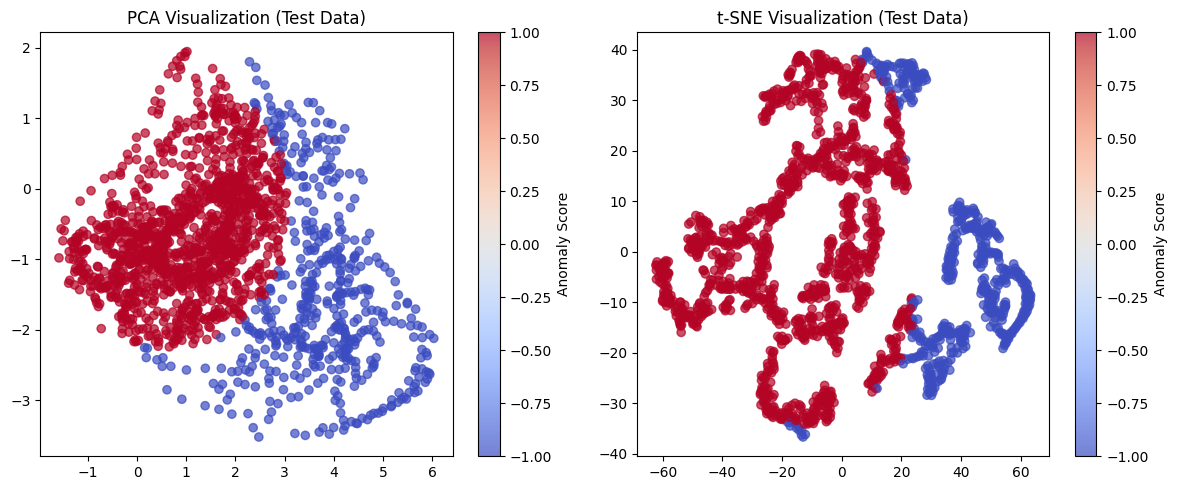

In [73]:
test_anomaly_score = test_pred  # -1 untuk anomali, 1 untuk normal

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_anomaly_score, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Anomaly Score')
plt.title("PCA Visualization (Test Data)")

plt.subplot(1, 2, 2)
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=test_anomaly_score, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Anomaly Score')
plt.title("t-SNE Visualization (Test Data)")

plt.tight_layout()
plt.show()

In [144]:

import plotly.graph_objects as go

# Pastikan test_results memiliki index sebagai timestamp

# Buat plot utama (water level)
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=test_results.index,
    y=test_results['water_level'],
    mode='lines',
    name='Water Level',
    line=dict(color='blue')
))

# Filter data anomali
anomalies = test_results[test_results['anomaly'] == -1]

fig.add_trace(go.Scatter(
    x=anomalies.index,
    y=anomalies['water_level'],
    mode='markers',
    name='Anomaly',
    marker=dict(color='red', size=8, symbol='x')
))

# Update layout untuk visualisasi yang lebih jelas
fig.update_layout(
    title='Deteksi Anomali pada Water Level dengan One-Class SVM',
    xaxis_title='Timestamp',
    yaxis_title='Water Level (cm)',
    template='plotly_white',
    legend=dict(x=0, y=1)
)

fig.show()


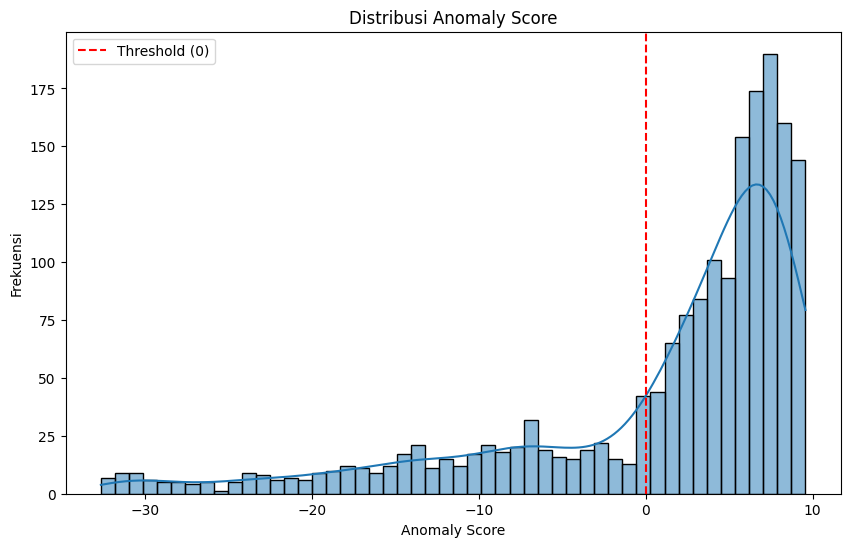

In [141]:

plt.figure(figsize=(10, 6))
sns.histplot(test_results['anomaly_score'], kde=True, bins=50)
plt.axvline(x=0, color='r', linestyle='--', label='Threshold (0)')  # Default threshold Isolation Forest
plt.title('Distribusi Anomaly Score')
plt.xlabel('Anomaly Score')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()